# How to work with istSOS
## An example of basic data consistency checks

In the next cell we are going to:

* load the autoreload extension useful to keep update the external code library
* activated the autoreload
* activate the plot of graph directly inside jupyter

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib
%matplotlib inline

!pip install oatlib==0.0.7rc1

try:
    from oatlib import sensor, oat_utils
except ImportError:
    !pip install oatlib
    from oatlib import sensor, oat_utils

  Using cached oatlib-0.0.7rc1-py3-none-any.whl (45 kB)
  Attempting uninstall: oatlib
    Found existing installation: oatlib 0.0.6rc2
    Uninstalling oatlib-0.0.6rc2:
      Successfully uninstalled oatlib-0.0.6rc2


### ⚒ Now we load some other libraries needed by this notebook

In [2]:
import requests
from dateutil import parser
import matplotlib.pyplot as plt
from statistics import stdev
import json

### ⚒ Set istSOS variables:

In [4]:
server = 'http://istsos.org/istsos'
service = 'hydro'
user = None
pwd = None

### ⚒ List all the procedures

In [5]:
procedures = oat_utils.get_istSOS_Procedures(server, service, user, pwd)

The variable procedures is now a **LIST** of **DICTIONARIES**.   
Each object contains the information of a procedure such as:
*sensortype, name, assignedid, offerings, id,
samplingTime, observedproperties, description.*

### ⚒ Let's print some information on procedures

In [6]:
print(f"Number of the procedures fetched: {len(procedures)}")
print(f"\nKeys for each procedure: {procedures[0].keys()}")
print(f'\nNames of the procedures fetched:')
for procedure in procedures:
    print('\t' + procedure['name'])

Number of the procedures fetched: 3

Keys for each procedure: dict_keys(['id', 'name', 'description', 'assignedid', 'sensortype', 'samplingTime', 'observedproperties', 'offerings'])

Names of the procedures fetched:
	P_CAV
	Q_MAG_LOD
	T_CAV


### ⚒ Now we are going to choose one procedure from the list above
to retrieve the ***time_interval*** of the data and the observed properties

In [9]:
procedure = oat_utils.filter_procedures(procedures,'name','=','T_CAV')[0]
procedure

{'id': 1,
 'name': 'T_CAV',
 'description': None,
 'assignedid': '28e70565c24f11ec91980242c0a8f003',
 'sensortype': 'insitu-fixed-point',
 'samplingTime': {'beginposition': '2019-01-01T01:10:00+0100',
  'endposition': '2020-01-01T00:00:00+0100'},
 'observedproperties': [{'name': 'air-temperature', 'uom': '°C'}],
 'offerings': ['temporary']}

### ⚒ Take a look at the specific procedure properties

In [10]:
time_interval = '/'.join([
                         procedure['samplingTime']['beginposition'],
                         procedure['samplingTime']['endposition']
                        ])

print(f'Time interval: {time_interval}')

# the variable observed_properties is a list of dict
observed_properties = procedure['observedproperties']

print(
    '\nNumber of observed properties for the procedure {}: {}'.format(
        procedure['name'],
        len(observed_properties)
    )
)

print(
    '\nList of the observed properties: {}'.format(observed_properties)
)




Time interval: 2019-01-01T01:10:00+0100/2020-01-01T00:00:00+0100

Number of observed properties for the procedure T_CAV: 1

List of the observed properties: [{'name': 'air-temperature', 'uom': '°C'}]


### ⚒ Load data from *istSOS* using *OAT*:

In [18]:
event_time = '2019-05-01T00:10:00+0100/2019-06-01T02:00:00+0200'

observed_property_name = observed_properties[0]['name']
observed_property_uom = observed_properties[0]['uom']

istsos_url = '{}/{}'.format(server, service)

#basic_auth = (user, pwd)
basic_auth = None

SENSOR = sensor.Sensor.from_istsos(
    service=istsos_url,
    observed_property='temperature',
    procedure=procedure['name'],
    verifySSL=True
)

### ⚒ See what SENSOR looks like --> it has the metadata automatically filled

In [19]:
SENSOR

name: T_CAV
desc: Cavergno
lat: 133073.0
lon: 690081.0
alt: 455.0
tz: 0
unit: b'\xc2\xb0C'
prop: temperature
freq: None
statflag: None
use: True
data_availability: ['2019-01-01T00:10:00.000000Z', '2019-12-31T23:00:00.000000Z']
ts: None

### ⚒ Now we gather the actual observations

In [20]:
SENSOR.ts_from_istsos(
    service=istsos_url,
    observed_property=':{}'.format(observed_property_name.replace('-',':')),
    procedure=procedure['name'],
    basic_auth=None,
    # aggregate_function='AVG',
    # aggregate_interval='PT10M',
    event_time=event_time
)
SENSOR

name: T_CAV
desc: Cavergno
lat: 133073.0
lon: 690081.0
alt: 455.0
tz: +01:00
unit: b'\xc2\xb0C'
prop: temperature
freq: None
statflag: None
use: True
data_availability: ['2019-04-30T23:20:00.000000000', '2019-06-01T00:00:00.000000000']
ts:                             data  quality
time                                     
2019-05-01 00:20:00+01:00  10.54      210
2019-05-01 00:30:00+01:00  10.37      210
...                          ...      ...
2019-06-01 00:50:00+01:00  13.83      210
2019-06-01 01:00:00+01:00  13.39      210

[4469 rows x 2 columns]

### ⚒ Plotting the TimeSeries

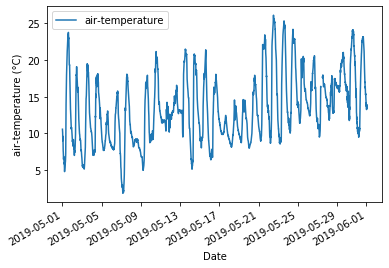

In [21]:
SENSOR.ts['data'].plot(legend=True, label=observed_property_name)
plt.ylabel('{} ({})'.format(observed_property_name, observed_property_uom))
plt.xlabel('Date')
plt.show()

## Quality check functions

[Click me](./qc_aws.pdf)

### ⚒ define the functions for quality checks

In [22]:
range_values = [-80, 60]

# verify that data are within a plausible range for the observed variable
# ranege_values: a list of 2 values that defines the interval
def plausible_value_check( x, range_values):
    if x >= range_values[0] and x <= range_values[1]:
        return 300
    else:
        return False

# verify that data changes in consecutive steps are within 4 sigma
# x: a list of 3 consecutive values and the central value is the one 
# to be evaluated
def time_consistency_check(x):
    if len(x) == 3:
        sum_abs_val = abs(x[1] - x[0]) + abs(x[1] - x[2])
        four_std = 4*stdev(x)
        if sum_abs_val <= four_std:
            return 400
        else:
            return False
    else:
        return False

### ⚒ apply the functions on a moving windows along the series and then update the series with the new indexes

- rolling(T) applies a moving windows of T width
- apply(X) applies to the moving window the function X

In [23]:
try:
    ts_tmp = SENSOR.ts['data'].rolling(1).apply(lambda x: plausible_value_check(x, range_values), raw=True)
    SENSOR.ts['quality'].update(ts_tmp.where(lambda x : x>0))
    ts_tmp2 = SENSOR.ts['data'].rolling('1440s').apply(lambda x: time_consistency_check(x), raw=True)
    SENSOR.ts['quality'].update(ts_tmp2.where(lambda x : x>0))
    print("Data checked.")
except:
    print("Can't check data.")

Data checked.


### ⚒ Filter values with QI == 400

In [24]:
SENSOR_400 = SENSOR.copy()
SENSOR_400.ts = SENSOR.ts[SENSOR.ts['quality'] == 400]

SENSOR_400.ts

,data,quality
time,,
2019-05-01 00:40:00+01:00,10.20,400
2019-05-01 00:50:00+01:00,10.04,400
...,...,...
2019-06-01 00:50:00+01:00,13.83,400
2019-06-01 01:00:00+01:00,13.39,400


### ⚒ Calculate statistics

In [27]:
MAX_COL = 'T_MAX'
TIME_MAX_COL = 'TIME_' + MAX_COL
MIN_COL = 'T_MIN'
TIME_MIN_COL = 'TIME_' + MIN_COL
MEAN_COL = 'T_MEAN'
COUNT = '{}_COUNT'.format(MEAN_COL)

daily_max = oat_utils.sensorStats(
    SENSOR_400, 
    frequency= 'D',
    stat='max',
    column_name=MAX_COL
)
daily_min = oat_utils.sensorStats(
    SENSOR_400, 
    frequency= 'D',
    stat='min',
    column_name=MIN_COL
)
daily_mean = oat_utils.sensorStats(
    SENSOR_400,
    frequency= 'D',
    stat='mean',
    column_name=MEAN_COL
)

/home/maxi/GIT/istSOS_2.4.0_workshop_mexico_2020/venv/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/maxi/GIT/istSOS_2.4.0_workshop_mexico_2020/venv/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [28]:
daily_max

name: T_CAV
desc: Cavergno
lat: 133073.0
lon: 690081.0
alt: 455.0
tz: +01:00
unit: b'\xc2\xb0C'
prop: temperature
freq: D
statflag: None
use: True
data_availability: ['2019-04-30T23:20:00.000000000', '2019-06-01T00:00:00.000000000']
ts:                            T_MAX quality                 TIME_T_MAX
2019-05-01 00:00:00+01:00  23.78     400  2019-05-01 14:50:00+01:00
2019-05-02 00:00:00+01:00  19.09     400  2019-05-02 11:00:00+01:00
...                          ...     ...                        ...
2019-05-31 00:00:00+01:00  23.18     400  2019-05-31 16:20:00+01:00
2019-06-01 00:00:00+01:00  13.92     400  2019-06-01 00:10:00+01:00

[32 rows x 3 columns]

In [29]:
daily_min

name: T_CAV
desc: Cavergno
lat: 133073.0
lon: 690081.0
alt: 455.0
tz: +01:00
unit: b'\xc2\xb0C'
prop: temperature
freq: D
statflag: None
use: True
data_availability: ['2019-04-30T23:20:00.000000000', '2019-06-01T00:00:00.000000000']
ts:                             T_MIN quality                 TIME_T_MIN
2019-05-01 00:00:00+01:00   4.744     400  2019-05-01 05:30:00+01:00
2019-05-02 00:00:00+01:00   6.632     400  2019-05-02 23:50:00+01:00
...                           ...     ...                        ...
2019-05-31 00:00:00+01:00   9.450     400  2019-05-31 05:10:00+01:00
2019-06-01 00:00:00+01:00  13.230     400  2019-06-01 00:20:00+01:00

[32 rows x 3 columns]

### ⚒ calculate completness

In [31]:
daily_mean.ts['Completeness (%)'] = daily_mean.ts['T_MEAN_COUNT'] / (6*24)*100
daily_mean

name: T_CAV
desc: Cavergno
lat: 133073.0
lon: 690081.0
alt: 455.0
tz: +01:00
unit: b'\xc2\xb0C'
prop: temperature
freq: D
statflag: None
use: True
data_availability: ['2019-04-30T23:20:00.000000000', '2019-06-01T00:00:00.000000000']
ts:                               T_MEAN  T_MEAN_COUNT  Completeness (%)
time                                                                
2019-05-01 00:00:00+01:00  13.659429           140         97.222222
2019-05-02 00:00:00+01:00  11.044090           144        100.000000
...                              ...           ...               ...
2019-05-31 00:00:00+01:00  16.288194           144        100.000000
2019-06-01 00:00:00+01:00  13.677143             7          4.861111

[32 rows x 3 columns]

⚒  plot the series

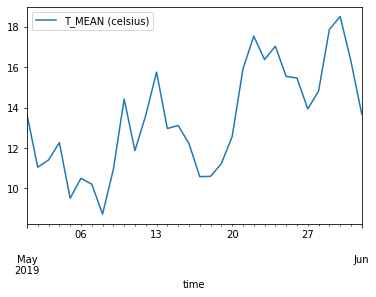

In [32]:
daily_mean.ts['T_MEAN'].plot(legend=True, label='T_MEAN (celsius)')

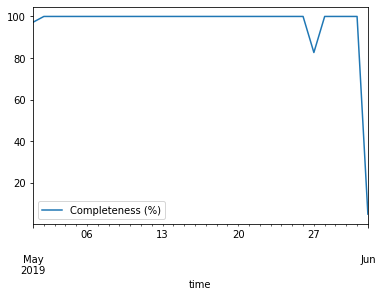

In [33]:
daily_mean.ts['Completeness (%)'].plot(legend=True, label='Completeness (%)')